## Importing required libraries

In [112]:
import sys
sys.path.append('/home/aistudio/external-libraries')

import jax
import jax.numpy as jnp
import jax.random as random

import time
import math
import numpy as np
import pandas as pd

import optax
import jaxopt
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.gridspec as gridspec
from typing import Tuple
import spectral_method_2 as sm

import scipy.io
from scipy.stats import qmc
from scipy.special import factorial
jax.config.update("jax_enable_x64", True)

font_path = '/home/aistudio/Times_New_Roman.ttf'
prop = font_manager.FontProperties(fname=font_path)

## Config for solving DDE

In [113]:
config = {
    "path_lag": 0.0625,
    "real_k": 0.1,
    "tmin": 0.,
    "tmax": 10.,
    "initial_key": 0,
    "conds": [0., 0.],
    "netLayers": [1, 20,40, 20, 1],
    "activation_function": 1,
    "record_info": False,
    "gap": 2000,
    "N_f": 5000,
    "loss_threshold": 1e-10,
    "step_epochs": [2000, 10000],
    "initial_lr" : 1e-3,
    "cosine_decay_steps": 1000,
    "cosine_alpha": 0.01,
    "DDE23_data_root_path": "/home/aistudio/DDE_2rd_revision/data/ex4.1.2",
    "result_save_path": "/home/aistudio/DDE_2rd_revision/result/ex4.1.2"
}
config["real_lag"] = config["path_lag"] * jnp.pi

## Defining the Delay Differential Equation
Let $ y'(t) = k\cdot y(t) - \frac{\pi}{2\tau} e^{k \tau} y(t-\tau) $, for $ t \leq 0 $, where $ y(t) = e^{kt}\sin(\frac{\pi t}{2\tau}) $.

In [114]:
# Define the differential equation
def DDE(t, u, lag, k):
    # Derivative of u at time t
    u_t = jax.grad(lambda s: jnp.sum(u(s)))(t)

    # Evaluate the DDE right-hand side
    delayed_term = jnp.where(
        t >= lag,
        u(t - lag),
        -jnp.cos(jnp.pi * t / (2*lag)) * jnp.exp(k * (t-lag))
    )
    
    coeff = (jnp.pi / (2 * lag)) * jnp.exp(k * lag)
    rhs = k*u(t) - coeff * delayed_term

    return u_t - rhs

## Construct the DNNs and initialize parameters

In [115]:
# Define the DNNs model
def DNNs(params, x, activation_function=config['activation_function']):
    kappa = jnp.exp(params[-1])

    w, b = params[0]
    x = kappa * jnp.dot(x, w) + b
    x = jnp.sin(x)

    for w, b in params[1:-2]:
        x = jnp.dot(x, w) + b
        x = jnp.tanh(x)

    w, b = params[-2]
    x = jnp.dot(x, w) + b
    return x

# Xavier initialization for the layer parameters
def random_layer_params_xavier(m, n, key):
    xavier_stddev = jnp.sqrt(2.0 / (m + n))

    w_key, b_key = jax.random.split(key)

    weights = xavier_stddev * jax.random.truncated_normal(
        w_key, lower=-2.0, upper=2.0, shape=(m, n)
    )
    biases = jnp.zeros((n,))

    return weights, biases

# Initialize parameters for all layers in a fully-connected neural network with the specified sizes
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params_xavier(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Define the loss function

In [116]:
@jax.jit
def loss_fun1(params, lag, k, inPoints, conds):
    t_c = inPoints[:, [0]]
    ufunc = lambda t: DNNs(params, t)

    # Compute the loss from the differential equation
    loss_f = jnp.mean(DDE(t_c, ufunc, lag, k)**2)

    # Compute the loss from the initial conditions
    t_0, u_0 = conds[:, [0]], conds[:, [1]]
    loss_init = jnp.mean((ufunc(t_0) - u_0)**2)

    # Total loss
    loss_total = loss_f + loss_init

    w_f = loss_f / loss_total
    w_init = loss_init / loss_total

    loss_weighted = loss_f * w_f + loss_init * w_init

    return loss_weighted, (loss_f, loss_init)

@jax.jit
def loss_fun2(params, lag, k, inPoints, conds, initial_weights):
    t_c = inPoints[:, [0]]
    ufunc = lambda t: DNNs(params, t)

    # Compute the loss from the differential equation
    loss_f = jnp.mean(DDE(t_c, ufunc, lag, k)**2)

    # Compute the loss from the initial conditions
    t_0, u_0 = conds[:, [0]], conds[:, [1]]
    loss_init = jnp.mean((ufunc(t_0) - u_0)**2)

    w_f, w_init = initial_weights[0], initial_weights[1]

    loss_weighted = loss_f * w_f + loss_init * w_init

    return loss_weighted, (loss_f, loss_init)

## Two-step neural network training

In [117]:
# First Step：Adam Optimizer
def train_adam(params, lag, k, inPoints, conds, record_info, num_epochs, start_epoch=0, log_interval=100, print_interval=1000):
    phase_epochs = []
    phase_losses = []
    phase_loss_f = []
    phase_loss_init = []

    scheduler = optax.cosine_decay_schedule(
        init_value=config['initial_lr'],
        decay_steps=config['cosine_decay_steps'],
        alpha=config['cosine_alpha']
    )
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    @jax.jit
    def update_adam(params, lag, k, inPoints, conds, opt_state):
        (loss, (loss_f, loss_init)), grads = jax.value_and_grad(loss_fun1, has_aux=True)(
            params, lag, k, inPoints, conds
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, (loss, (loss_f, loss_init))

    if record_info:
        for epoch in range(num_epochs):
            params, opt_state, (loss, (loss_f, loss_init)) = update_adam(
                params, lag, k, inPoints, conds, opt_state
            )
            current_epoch = start_epoch + epoch

            if record_info and current_epoch % log_interval == 0:
                phase_epochs.append(current_epoch)
                phase_losses.append(loss)
                phase_loss_f.append(loss_f)
                phase_loss_init.append(loss_init)

            if record_info and current_epoch % print_interval == 0:
                print(f"Epoch {current_epoch}, Total Loss: {loss:.3e}, DDE Loss: {loss_f:.3e}, IC Loss: {loss_init:.3e}")
        
        return params, phase_epochs, phase_losses, phase_loss_f, phase_loss_init, (loss_f, loss_init)
    else:
        now_epoch = 0
        while now_epoch < num_epochs:
            params, opt_state, (loss, (loss_f, loss_init)) = update_adam(
                params, lag, k, inPoints, conds, opt_state
            )
            now_epoch += 1
        return params, None, None, None, None, (loss_f, loss_init)


# Second Step：L-BFGS Optimizer
def train_lbfgs(params, lag, k, inPoints, conds, initial_weights,
                record_info, num_epochs=10000, gap=100, start_epoch=0):

    phase_epochs = []
    phase_losses = []
    phase_loss_f = []
    phase_loss_init = []

    current_params = params

    if record_info:
        solver = jaxopt.BFGS(
            fun=loss_fun2,
            tol=1e-16,
            maxiter=gap,
            has_aux=True,
            verbose=False
        )

        for epoch in range(start_epoch, start_epoch + num_epochs + 1, gap):
            sol = solver.run(current_params, lag, k, inPoints, conds, initial_weights)
            current_params = sol.params
            loss, (loss_f, loss_init) = sol.state.value, sol.state.aux

            phase_losses.append(loss)
            phase_loss_f.append(loss_f)
            phase_loss_init.append(loss_init)
            phase_epochs.append(epoch + gap)

            print(f"Epoch {epoch+gap}, Total Loss: {loss:.3e}, DDE Loss: {loss_f:.3e}, IC Loss: {loss_init:.3e}")

        return current_params, phase_epochs, phase_losses, phase_loss_f, phase_loss_init, (loss_f, loss_init)

    else:
        solver = jaxopt.BFGS(
            fun=loss_fun2,
            tol=1e-16,
            maxiter=num_epochs,
            has_aux=True,
            verbose=False
        )
        sol = solver.run(current_params, lag, k, inPoints, conds, initial_weights)
        current_params = sol.params
        return current_params, None, None, None, None, sol.state.aux


# Get the weights from the fist step
def get_fixed_weights(loss_tuple):
    losses = jnp.array([jax.lax.stop_gradient(l) for l in loss_tuple])
    return losses / jnp.sum(losses)

## Boundary Condition Initialization and Random Sampling Strategy for Solving DDE

In [118]:
lag = config["real_lag"]
k = config['real_k']

# conds represents the initial condition y(0) = 1
conds = jnp.array(config['conds']).reshape(1,-1)

# Initial key for random number generator
ik = config['initial_key']

# Number of internal random points
N_f = config['N_f']

# Range for sampling points
tmin, tmax = config['tmin'], config['tmax']

# Generate random points within the specified range
jaxKey = jax.random.PRNGKey(ik)

sampler = qmc.LatinHypercube(d=1)

sample = sampler.random(n=N_f)
Inn_T = qmc.scale(sample, tmin, tmax)
inPoints = jnp.array(Inn_T)

# Network architecture
netLayers = config['netLayers']

# Initialize network parameters
params = init_network_params(netLayers, jaxKey)
params.append(jnp.array([0.]))

## Training

In [119]:
epoch_history = []
loss_history = []
loss_f_history = []
loss_init_history = []

adam_epochs = config["step_epochs"][0]
lbfgs_epochs = config["step_epochs"][1]
stage1_epochs = adam_epochs + lbfgs_epochs

record_info = config['record_info']
gap = config['gap']

start_time_nn = time.time()

# 第一阶段adam训练
params, hist1_epoch, hist1_loss, hist1_loss_f, hist1_loss_init, loss_components = train_adam(params, lag, k, inPoints, conds, record_info, adam_epochs, start_epoch=0, log_interval=100, print_interval=1000)

initial_weights = get_fixed_weights(loss_components)

# 第二阶段lbfgs训练
params, hist2_epoch, hist2_loss, hist2_loss_f, hist2_loss_init, _ = train_lbfgs(params, lag, k, inPoints, conds, initial_weights, record_info, num_epochs=lbfgs_epochs, gap=gap, start_epoch=adam_epochs)

end_time_nn = time.time()
time_nn = end_time_nn - start_time_nn

# 合并训练记录
if record_info:
    epoch_history.extend(hist1_epoch + hist2_epoch)
    loss_history.extend(hist1_loss + hist2_loss)

## Result visualization

In [120]:
# save path
result_save_root_path = os.path.join(config['result_save_path'],f"tau_{config['path_lag']}pi")
os.makedirs(result_save_root_path, exist_ok=True)

### DDE23 solution

In [121]:
# MATLAB solution
dde_solve_path = os.path.join(config['DDE23_data_root_path'], f"DDE23_ex4.1.2_tau_{config['path_lag']}pi.csv")
data = pd.read_csv(dde_solve_path)
data_sorted = data.sort_values(by=data.columns[0])
dde_t = data_sorted.iloc[:, 0].to_numpy().reshape(-1, 1)
dde_sol = data_sorted.iloc[:, 1].to_numpy().reshape(-1, 1)

### Analytical solution
The delay differential equation has an explicit analytical solution, which can be specifically expressed as
\begin{equation}  
    y(t) = e^{kt}\cdot \sin(\frac{\pi t}{2\tau})
\end{equation}

In [122]:
T = dde_t
rr_sol = jnp.exp(k*T) * jnp.sin(jnp.pi * T / (2*lag))

### spectral solution

In [123]:
start_time_sm = time.time()
_, _, subintervals = sm.main(config['real_k'],config['real_lag'], config['tmax'], 5)
sm_sol = sm.get_interpolated_y(T, subintervals, k=config['real_k'], tau=config['real_lag'])
end_time_sm = time.time()
time_sm = end_time_sm - start_time_sm

### Sol

In [124]:
# Neural network solution
nn_sol = DNNs(params, T.reshape(-1, 1))

# Absolute and relative errors between nn_sol and rr_sol
abs_error_nn_rr = np.abs(nn_sol - rr_sol)
rel_error_nn_rr = np.linalg.norm(nn_sol - rr_sol, ord=2) / np.linalg.norm(rr_sol, ord=2)
mae_nn_rr = np.mean(abs_error_nn_rr)  # Calculate Mean Absolute Error (MAE)

# # Absolute and relative errors between rr_sol and dde_sol
abs_error_dde_rr = np.abs(dde_sol - rr_sol)
rel_error_dde_rr = np.linalg.norm(dde_sol - rr_sol, ord=2) / np.linalg.norm(rr_sol, ord=2)
mae_dde_rr = np.mean(abs_error_dde_rr)  # Calculate Mean Absolute Error (MAE)

# Absolute and relative errors between sm_sol and rr_sol
abs_error_sm_rr = np.abs(sm_sol - rr_sol)
rel_error_sm_rr = np.linalg.norm(sm_sol - rr_sol, ord=2) / np.linalg.norm(rr_sol, ord=2)
mae_sm_rr = np.mean(abs_error_sm_rr)  # Calculate Mean Absolute Error (MAE)

# Save results to a txt file
save_path = os.path.join(result_save_root_path, f"Results_ex4.1.2_tau_{config['path_lag']}pi.txt")
results_path = os.path.join(os.getcwd(), save_path)
with open(results_path, "w") as file:
    file.write(f"Real Lag: {config['real_lag']}\n")
    file.write("Relative and Mean Absolute Errors\n")
    file.write("=================================\n")
    file.write(f"Relative error between nn_sol and rr_sol: {rel_error_nn_rr}\n")
    file.write(f"Mean Absolute Error (MAE) between nn_sol and rr_sol: {mae_nn_rr}\n")
    file.write(f"Running time: {time_nn}\n")
    file.write("\n")
    file.write(f"Relative error between sm_sol and rr_sol: {rel_error_sm_rr}\n")
    file.write(f"Mean Absolute Error (MAE) between sm_sol and rr_sol: {mae_sm_rr}\n")
    file.write(f"Running time: {time_sm}\n")

# print(f"Results have been saved to {results_path}")

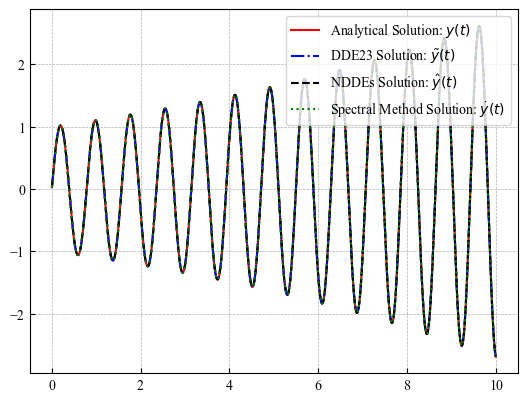

In [125]:
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

plt.plot(T,rr_sol,'-r',label='Analytical Solution: $y(t)$')
plt.plot(dde_t,dde_sol,'-.b',label='DDE23 Solution: $\\tilde{y}(t)$')
plt.plot(T,nn_sol,'--k',label='NDDEs Solution: $\hat{y}(t)$')
plt.plot(T,sm_sol,':g',label='Spectral Method Solution: $\dot{y}(t)$')

plt.legend(prop=prop, loc='upper right')

# plt.xlabel('$t$')
# plt.ylabel('$y$')

ax = plt.gca()

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

ax.tick_params(direction='in')

plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

save_path = os.path.join(result_save_root_path, f"Sol_ex4.1.2_tau_{config['path_lag']}pi.png")

plt.savefig(save_path, dpi=600, bbox_inches='tight')

plt.show()